### <font color = 'purple'> DATA 255 - HOMEWORK-5: BASIC GANs

#### <font color = 'blue'>Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:03<00:00, 8676981.17it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 176796.04it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3221391.25it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4091771.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

<font color = 'blue'>Pixel values ranges from -1 to 1 as we have transformed in the first step

In [3]:
# denormalising to view the image
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

<font color = 'blue'>Using the dictionary label_map to define the label names

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


Label: Ankle Boot


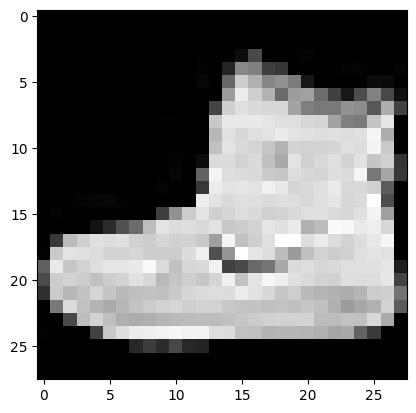

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
label_name = labels_map[label]
print('Label:', label_name)


<font color = 'blue'> Loading the image in batches

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 7, 5, 9, 6, 1, 7, 2, 7, 6, 9, 1, 8, 1, 4, 6, 6, 4, 5, 0, 7, 1, 5, 7,
        0, 0, 5, 7, 0, 0, 1, 6, 2, 9, 6, 6, 8, 5, 5, 3, 9, 9, 3, 4, 5, 1, 6, 4,
        5, 2, 3, 8, 4, 1, 7, 8, 2, 0, 5, 1, 3, 9, 4, 1, 1, 2, 0, 6, 5, 0, 5, 2,
        3, 7, 0, 7, 9, 9, 1, 5, 2, 3, 4, 5, 7, 0, 1, 6, 4, 7, 5, 8, 2, 5, 7, 8,
        2, 1, 9, 3])


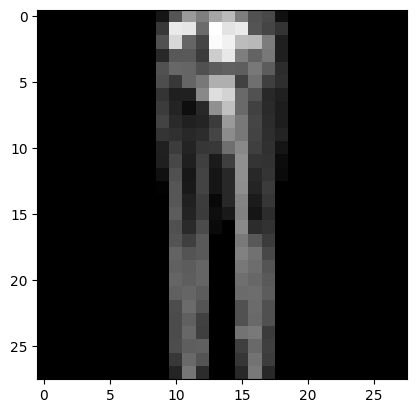

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

### <font color = 'blue'>Step2. Train the GAN model to produce images in this new domain.

#### <font color = 'brown'> Discriminator Network

<font color = 'blue'> Taking a simple feedforward NN for the discriminator. Each image of 28X28 as a vector of size 784

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

<font color = 'blue'> Moving model to our device

In [12]:
D.to(device);

#### <font color = 'brown'> Generator Network

<font color = 'blue'> Using feedfoward neural network with 3 layers for generator
<font color = 'blue'> Input: A vector or a matrix that is used as a seed for generating an image.
<font color = 'blue'> Output : vector of size 784, transformable to 28X28 pixel image

In [13]:
latent_size = 64

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

<font color = 'blue'>Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [15]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

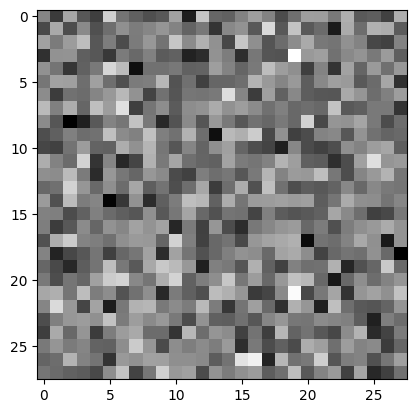

In [16]:
plt.imshow(gen_imgs[0], cmap='gray');

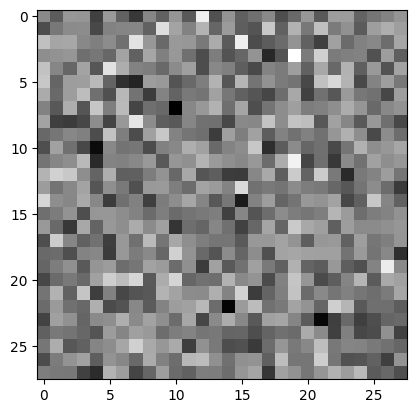

In [17]:
plt.imshow(gen_imgs[1], cmap='gray');

<font color = 'blue'> Outputs from the generator is just a random noise

In [18]:
G.to(device);

#### <font color = 'brown'>Training the Discriminator

<font color = 'blue'> Discriminator is used to classify if the image generated by generator is real or fake. Mostly a binary classification problem, therefor using binary cross entropy loss function

In [19]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

#### <font color = 'brown'>Training the Generator

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

#### <font color = 'blue'>Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

#### <font color = 'brown'>Train the Model

<font color = 'blue'> Creating a directory to save outputs from generator

In [23]:
import os

sample_dir_fashion_mnist = 'samples'
if not os.path.exists(sample_dir_fashion_mnist):
    os.makedirs(sample_dir_fashion_mnist)

<font color = 'blue'> Saving a batch of real images so as to compare with the generated image

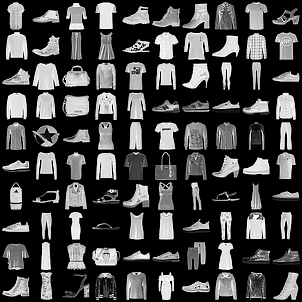

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir_fashion_mnist, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir_fashion_mnist, 'real_images.png'))

<font color = 'blue'> Saving the generated image at the end of every epoch. Also using a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


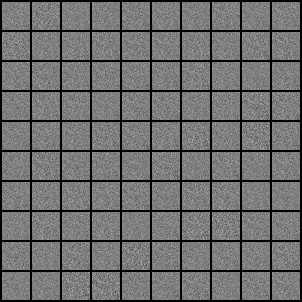

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir_fashion_mnist, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir_fashion_mnist, 'fake_images-0000.png'))

<font color = 'blue'> Training starts. We first train the discriminator and then generator

In [26]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0834, g_loss: 4.0202, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.1642, g_loss: 5.0850, D(x): 0.94, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0333, g_loss: 5.4670, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0263, g_loss: 4.5170, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0369, g_loss: 3.9279, D(x): 1.00, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0178, g_loss: 5.6039, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0285, g_loss: 6.0264, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0594, g_loss: 7.6101, D(x): 1.00, D(G(z)): 0.05
Epoch [2/300], Step [600/600], d_loss: 0.0216, g_loss: 8.0276, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1027, g_loss: 4.9462, D(x): 0.98, D(G(z)): 0.05
Epoch [3/300], Step [400/6

<font color = 'blue'>We can see how loss is changed over time. Generator Loss started with 4.02 and at 300 th epoch it was at 1.11.
It is expected too as generator will struggle initially to generate images like real, as it is still learning. Towards the later epoch we see generator getting low suggested the improvement in generating real images. It has reduced over time.
Whereas, for discriminator loss we see it has increased from 0.08 to 0.93. This is quite understandable too, as initially is able to distinguish well between real and fake images as generator images were mostly noises initially. However, in the later epochs, generator performance improved and discriminator found it hard to distinguish between real and fake. We also see that discriminator is increased but not that very high. The same can also be read from D(x) and D(G(z))

#### <font color = 'blue'>Step4. Save the model weights in the folder to be used later.

In [27]:
# Save the model checkpoints
torch.save(G.state_dict(), 'Fashion_Gen.ckpt')
torch.save(D.state_dict(), 'Fashion_Dis.ckpt')

<font color = 'blue'> Visualising the generated images at the given epoch

In [28]:
from IPython.display import Image
from torchvision.utils import save_image

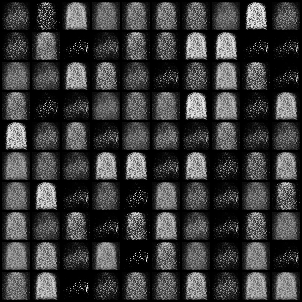

In [29]:
Image('./samples/fake_images-0005.png')

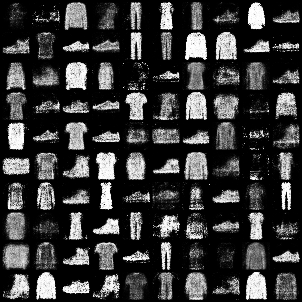

In [30]:
Image('./samples/fake_images-0100.png')

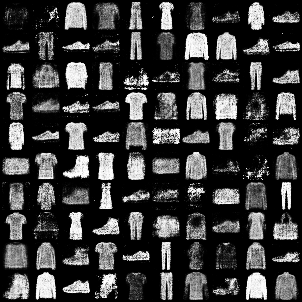

In [31]:
Image('./samples/fake_images-0200.png')

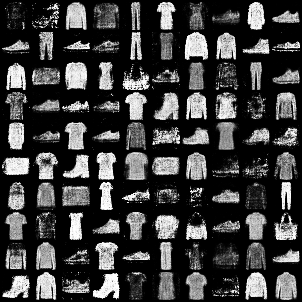

In [32]:
Image('./samples/fake_images-0300.png')

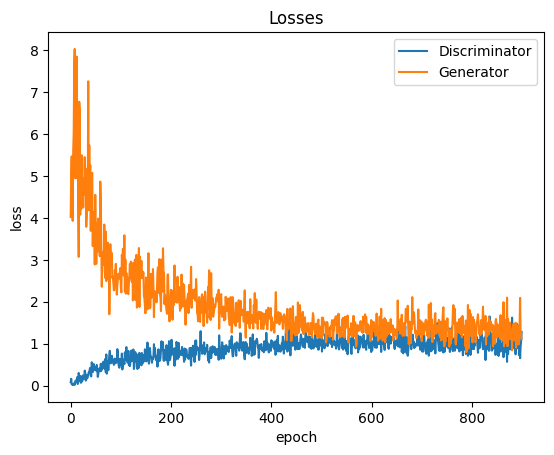

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

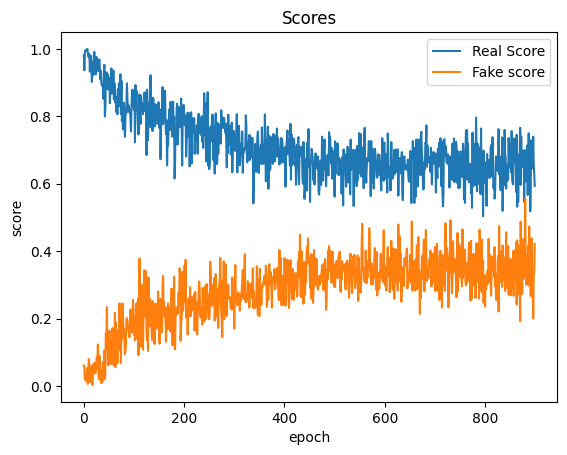

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

<font color = 'blue'> The generator loss starts very high and gradually decreases to stabilize around 1.4 whereas the discriminator loss begins near zero and slowly increases to stabilize around 0.8-1. This shows a clear learning progression. We see in early stages discriminator is very effective and generator is struggling. At the mddle stage, Generator performance improves and dicriminator becomes less certain. And at the last stages, both seems to be somewhat stable. To see more of the performance, we can try retraining to see if there can be improvement. The maintained gap between real and fake scores suggests the discriminator can still differentiate

#### <font color = 'blue'>Step5. Load the model using the saved weights.

In [35]:
G.load_state_dict(torch.load('Fashion_Gen.ckpt'))
D.load_state_dict(torch.load('Fashion_Dis.ckpt'))

<ipython-input-35-3c32b46fb218>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('Fashion_Gen.ckpt'))
<ipython-input-35-3c32b46fb218>:2: FutureW

<All keys matched successfully>

 <font color = 'blue'> The losses for generator and discriminator suggests that the model has not fully converged. The fluctuating generator loss indicate that further training or adjustments may improve the results. May be we can try to continue training for additional 100 epochs to see if the model stabilizes and improves.

#### <font color = 'blue'>Step 6: Re-train the GAN model to see if you can improve.

<font color = 'blue'> We have defined the optimizer again for generator and discriminator with lr = 0.0001 and loaded the saved model on device

In [36]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

# Ensure models are on the correct device
D.to(device)
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

<font color = 'blue'>Making new directory to save the generator output from retrained model

In [37]:
import os

sample_dir_fashion_mnist_retrain = 'samples_retrain'
if not os.path.exists(sample_dir_fashion_mnist_retrain):
    os.makedirs(sample_dir_fashion_mnist_retrain)

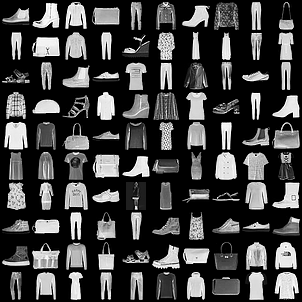

In [38]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir_fashion_mnist_retrain, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir_fashion_mnist_retrain, 'real_images.png'))

Saving fake_images-0000.png


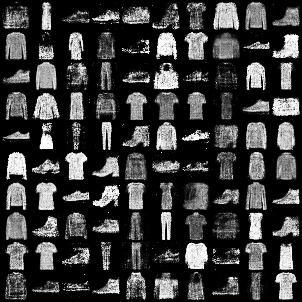

In [39]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images_retrain(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir_fashion_mnist_retrain, fake_fname), nrow=10)

# Before training
save_fake_images_retrain(0)
Image(os.path.join(sample_dir_fashion_mnist_retrain, 'fake_images-0000.png'))

<font color = 'blue'>Retraining the saved model with 100 epochs and changed lr

In [40]:
%%time

num_epochs = 150
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images_retrain(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 1.0359, g_loss: 1.1445, D(x): 0.63, D(G(z)): 0.34
Epoch [0/100], Step [400/600], d_loss: 1.0490, g_loss: 1.2254, D(x): 0.64, D(G(z)): 0.37
Epoch [0/100], Step [600/600], d_loss: 1.1330, g_loss: 1.1613, D(x): 0.61, D(G(z)): 0.39
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 1.0623, g_loss: 1.0847, D(x): 0.66, D(G(z)): 0.40
Epoch [1/100], Step [400/600], d_loss: 0.8882, g_loss: 1.2762, D(x): 0.68, D(G(z)): 0.32
Epoch [1/100], Step [600/600], d_loss: 0.9539, g_loss: 1.2278, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.2133, g_loss: 1.0948, D(x): 0.62, D(G(z)): 0.40
Epoch [2/100], Step [400/600], d_loss: 1.0034, g_loss: 1.3154, D(x): 0.66, D(G(z)): 0.37
Epoch [2/100], Step [600/600], d_loss: 0.9561, g_loss: 1.1882, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 1.1591, g_loss: 0.9686, D(x): 0.61, D(G(z)): 0.38
Epoch [3/100], Step [400/6

<font color = 'blue'> We see that generator loss decreased from 1.4787 to 0.93,and discriminator loss increased from 0.82 to 1.22. We see that generator performance has not significantly improved over the additional epochs.

#### <font color = 'blue'>Step 7: Save the model weights without using checkpoints.

In [41]:
# torch.save(G.state_dict(), 'Fashion_Gen_Ret.ckpt')
# torch.save(D.state_dict(), 'Fashion_Dis_Ret.ckpt')

torch.save(G, 'Fashion_Gen_Model.pth')
torch.save(D, 'Fashion_Dis_Model.pth')

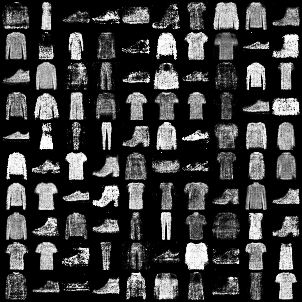

In [42]:
Image('./samples_retrain/fake_images-0005.png')

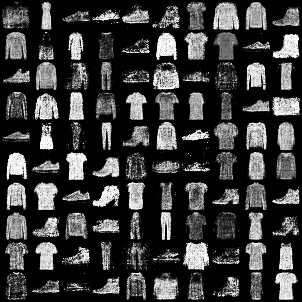

In [43]:
Image('./samples_retrain/fake_images-0030.png')

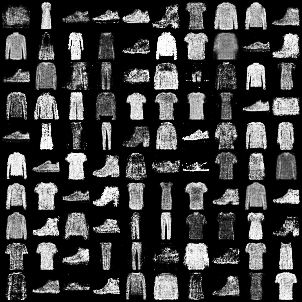

In [44]:
Image('./samples_retrain/fake_images-0080.png')

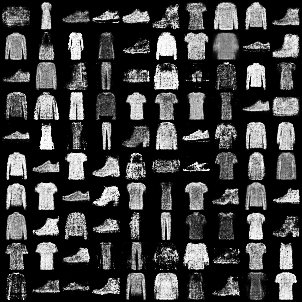

In [45]:
Image('./samples_retrain/fake_images-0100.png')

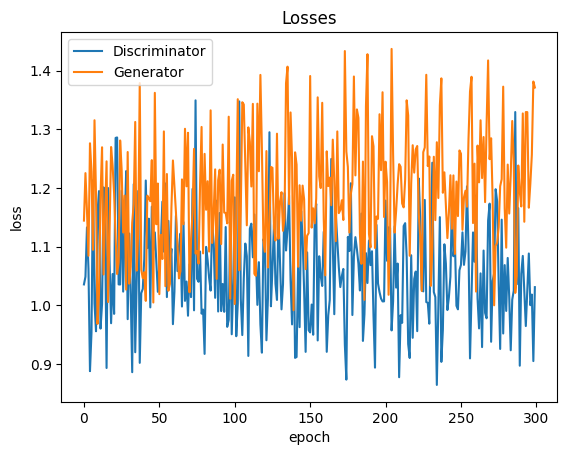

In [46]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

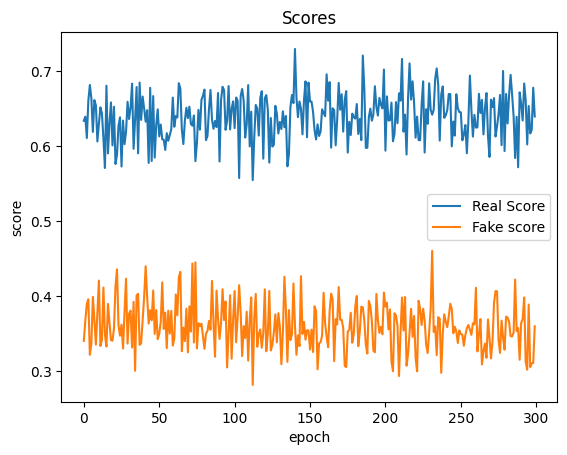

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

<font color = 'blue'>From the plots and the scores, losses generated, we see that losses for discriminator and generator are relatively stable, having fluctuation within consistent ranges. D_loss mostly stays b/w 0.9 & 1.2, whereas G_loss remains b/w 1.2 and 1.4, showing training to be stable. The clear separation between real and fake scores indicates the discriminator is effectively differentiating between real and generated samples. However, the persistent gap in scores between real and fake data indicates the generator hasn't managed to fully "fool" the discriminator.

<font color = 'blue'>In training, model seems to have reached stable equilibrium instead of showing continuous improvement. We can do various experiments with different architecture or with differnt LR, or with different loss functions.

#### <font color = 'blue'>Step 8: Load the model weights without using checkpoints.

In [48]:
# G.load_state_dict(torch.load('Fashion_Gen_Ret.ckpt'))
# D.load_state_dict(torch.load('Fashion_Dis_Ret.ckpt'))

G = torch.load('Fashion_Gen_Model.pth')
D = torch.load('Fashion_Dis_Model.pth')

<ipython-input-48-2d2cf3061506>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G = torch.load('Fashion_Gen_Model.pth')
<ipython-input-48-2d2cf3061506>:5: FutureWarning: Yo

#### <font color = 'blue'> Thank You!

<font color = 'blue'> Part 2 in another NB